In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Centralized Baselines

In [14]:
# Load preprocessed data
train_df = pd.read_csv('/content/drive/MyDrive/train_processed.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/test_processed.csv')

# Force numeric types where possible
train_df = train_df.apply(pd.to_numeric, errors='ignore')
test_df  = test_df.apply(pd.to_numeric, errors='ignore')

# Check shape
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Define feature groups
traffic_groups = {
    "SMS": ['sms_in', 'sms_out'],
    "Call": ['call_in', 'call_out'],
    "Internet": ['internet']
}


Train shape: (420, 6)
Test shape: (60, 6)


/tmp/ipython-input-1909692659.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  train_df = train_df.apply(pd.to_numeric, errors='ignore')
/tmp/ipython-input-1909692659.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  test_df  = test_df.apply(pd.to_numeric, errors='ignore')


In [15]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae

def plot_results(y_true, y_pred, model_name, traffic_type):
    plt.figure(figsize=(10,5))
    plt.plot(y_true.values[:100], label="Actual", color="black")
    plt.plot(y_pred[:100], label="Predicted", color="green")
    plt.title(f"{model_name} – {traffic_type} Traffic (First 100 Hours)")
    plt.xlabel("Time")
    plt.ylabel("Normalized Usage")
    plt.legend()
    plt.grid(True)
    plt.show()

def lstm_create_dataset(data, look_back=5):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, :-1])
        y.append(data[i+look_back, -1])
    return np.array(X), np.array(y)



===== SMS TRAFFIC =====

Target: sms_in


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

Target: sms_out


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== CALL TRAFFIC =====

Target: call_in
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

Target: call_out


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

===== INTERNET TRAFFIC =====

Target: internet


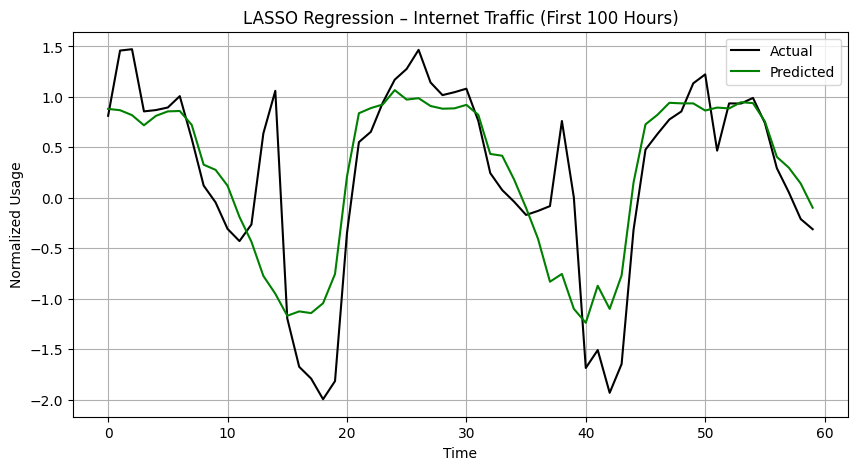

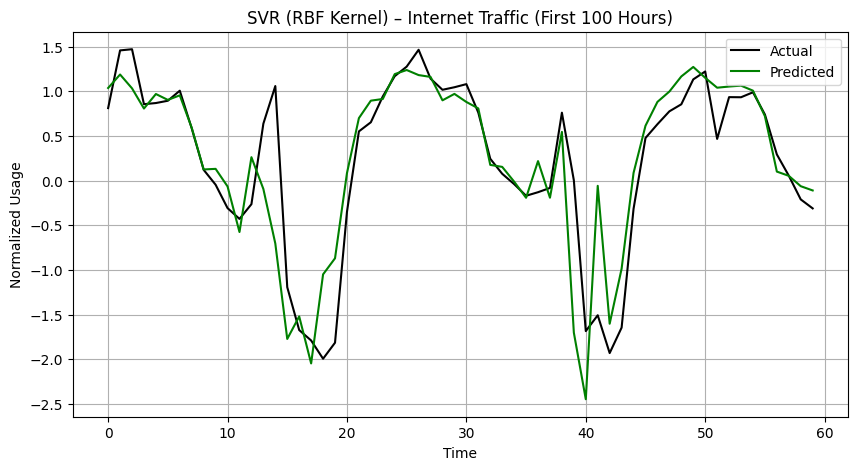

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


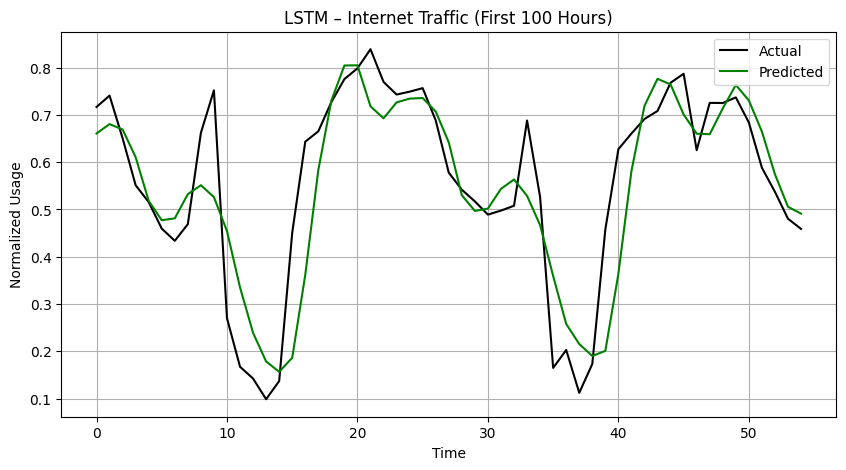

In [16]:
results = []

for traffic_type, target_cols in traffic_groups.items():
    print(f"\n===== {traffic_type.upper()} TRAFFIC =====")

    for target in target_cols:
        print(f"\nTarget: {target}")

        # Use only numeric features
        numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

        # Drop target(s) from features
        X_train = train_df[numeric_cols].drop(columns=target_cols, errors='ignore')
        X_test  = test_df[numeric_cols].drop(columns=target_cols, errors='ignore')
        y_train = train_df[target]
        y_test  = test_df[target]

        # ---------------- LASSO ----------------
        lasso = Lasso(alpha=0.01, max_iter=10000)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        mse, mae = evaluate(y_test, y_pred)
        results.append(['Lasso', traffic_type, mse, mae])
        if traffic_type == "Internet":
            plot_results(y_test, y_pred, "LASSO Regression", traffic_type)

        # ---------------- SVR ----------------
        svr = SVR(kernel='rbf', C=10, epsilon=0.05)
        svr.fit(X_train, y_train)
        y_pred = svr.predict(X_test)
        mse, mae = evaluate(y_test, y_pred)
        results.append(['SVR', traffic_type, mse, mae])
        if traffic_type == "Internet":
            plot_results(y_test, y_pred, "SVR (RBF Kernel)", traffic_type)

        # ---------------- LSTM ----------------
        scaler = MinMaxScaler()
        seq_train = pd.concat([X_train, y_train], axis=1)
        seq_test  = pd.concat([X_test, y_test], axis=1)
        train_scaled = scaler.fit_transform(seq_train)
        test_scaled  = scaler.transform(seq_test)

        X_train_seq, y_train_seq = lstm_create_dataset(train_scaled, 5)
        X_test_seq,  y_test_seq  = lstm_create_dataset(test_scaled, 5)

        model = Sequential([
            LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=16, verbose=0)

        y_pred = model.predict(X_test_seq).flatten()
        mse, mae = evaluate(y_test_seq, y_pred)
        results.append(['LSTM', traffic_type, mse, mae])
        if traffic_type == "Internet":
            plot_results(pd.Series(y_test_seq), y_pred, "LSTM", traffic_type)


In [18]:
# === FIX FOR DUPLICATE ENTRIES ===
df_results = pd.DataFrame(results, columns=['Method', 'Traffic_Type', 'MSE', 'MAE'])

# In case multiple entries exist for same Method–Traffic_Type, average them
df_results = df_results.groupby(['Method', 'Traffic_Type'], as_index=False).mean()

# Build pivot tables
pivot_mse = df_results.pivot(index='Method', columns='Traffic_Type', values='MSE')
pivot_mae = df_results.pivot(index='Method', columns='Traffic_Type', values='MAE')

# Combine both metrics into one table
final_table = pd.concat([
    pivot_mse.add_prefix('MSE_'),
    pivot_mae.add_prefix('MAE_')
], axis=1).reset_index()

# Reorder columns for consistency
expected_cols = ['Method', 'MSE_SMS', 'MSE_Call', 'MSE_Internet',
                 'MAE_SMS', 'MAE_Call', 'MAE_Internet']

# Some columns may be missing depending on which traffic types were evaluated
for col in expected_cols:
    if col not in final_table.columns:
        final_table[col] = np.nan

final_table = final_table[expected_cols].round(4)

print("\n=== FINAL COMPARISON TABLE ===")
print(final_table)

# Save table
final_table.to_csv('/content/drive/MyDrive/model_comparison_table.csv', index=False)



=== FINAL COMPARISON TABLE ===
Traffic_Type Method  MSE_SMS  MSE_Call  MSE_Internet  MAE_SMS  MAE_Call  \
0              LSTM   0.0119    0.0129        0.0109   0.0865    0.0906   
1             Lasso   0.1086    0.0978        0.3055   0.2645    0.2490   
2               SVR   0.0337    0.0361        0.2367   0.1334    0.1204   

Traffic_Type  MAE_Internet  
0                   0.0743  
1                   0.3839  
2                   0.2999  


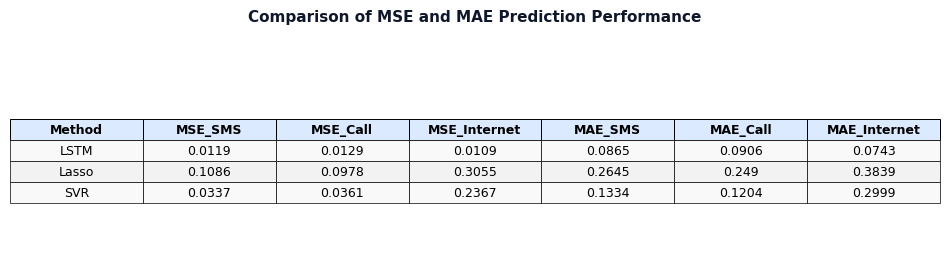

In [20]:
import matplotlib.pyplot as plt
from matplotlib import colors

# --- Create styled table ---
fig, ax = plt.subplots(figsize=(10, 2.8))
ax.axis('off')
ax.axis('tight')

# Make column headers bold and add alternating row colors
cell_colors = []
for i in range(len(final_table)):
    color = "#f9f9f9" if i % 2 == 0 else "#f2f2f2"
    cell_colors.append([color] * final_table.shape[1])

table = ax.table(
    cellText=final_table.values,
    colLabels=final_table.columns,
    cellLoc='center',
    colColours=["#dbeafe"] * final_table.shape[1],   # soft blue header
    cellColours=cell_colors,
    loc='center'
)

# --- Styling tweaks ---
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.3)

# Bold header text and align nicely
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='black')
        cell.set_linewidth(0.7)
    else:
        cell.set_linewidth(0.5)

# --- Add title ---
plt.title(
    "Comparison of MSE and MAE Prediction Performance",
    fontsize=11,
    fontweight='bold',
    pad=25,
    color="#0f172a"
)

plt.subplots_adjust(top=0.8, bottom=0.05)
plt.show()


In [21]:
fig.savefig('/content/drive/MyDrive/table3_comparison.png', dpi=300, bbox_inches='tight')


## Federated Averaging (FedAvg simulation) and SplitNN (VFL)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy

In [28]:
# Keep numeric columns only
train_df = train_df.select_dtypes(include=[np.number])
test_df  = test_df.select_dtypes(include=[np.number])

# Define traffic groups
traffic_groups = {
    "SMS": ['sms_in', 'sms_out'],
    "Call": ['call_in', 'call_out'],
    "Internet": ['internet']
}

In [29]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae

def plot_results(y_true, y_pred, model_name, traffic_type):
    plt.figure(figsize=(10,5))
    plt.plot(y_true[:100], label="Actual", color="black")
    plt.plot(y_pred[:100], label="Predicted", color="green")
    plt.title(f"{model_name} – {traffic_type} Traffic (First 100 Hours)")
    plt.xlabel("Time")
    plt.ylabel("Normalized Usage")
    plt.legend()
    plt.grid(True)
    plt.suptitle(
        f"{model_name} → RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}, "
        f"MAE: {mean_absolute_error(y_true, y_pred):.4f}",
        fontsize=9, y=0.96)
    plt.tight_layout()
    plt.show()


In [32]:
# ---------- FedAvg ----------
class SimpleNet(nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, out_dim)
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

def run_fedavg(X_train, y_train, X_test, y_test, num_clients=5, rounds=5, epochs=29, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    in_dim = X_train.shape[1]
    global_model = SimpleNet(in_dim).to(device)
    client_models = [SimpleNet(in_dim).to(device) for _ in range(num_clients)]
    total = len(X_train)
    split_size = total // num_clients

    # Split data for clients
    client_data = []
    for i in range(num_clients):
        start, end = i*split_size, (i+1)*split_size if i<num_clients-1 else total
        xi = torch.tensor(X_train.values[start:end], dtype=torch.float32).to(device)
        yi = torch.tensor(y_train.values[start:end], dtype=torch.float32).unsqueeze(1).to(device)
        client_data.append((xi, yi))

    for _ in range(rounds):
        global_weights = deepcopy(global_model.state_dict())
        for cm in client_models: cm.load_state_dict(global_weights)

        # Train locally
        for cm, (xi, yi) in zip(client_models, client_data):
            opt = optim.SGD(cm.parameters(), lr=lr)
            loss_fn = nn.MSELoss()
            cm.train()
            for _ in range(epochs):
                opt.zero_grad(); loss = loss_fn(cm(xi), yi); loss.backward(); opt.step()

        # Aggregate
        new_w = deepcopy(global_weights)
        for k in new_w.keys():
            stacked = torch.stack([cm.state_dict()[k] for cm in client_models], 0)
            new_w[k] = torch.mean(stacked, 0)
        global_model.load_state_dict(new_w)

    # Evaluate
    X_t = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_pred = global_model(X_t).cpu().numpy().flatten()
    mse, mae = evaluate(y_test, y_pred)
    return mse, mae, y_pred

In [33]:
# ---------- SplitNN (VFL) ----------
class ClientNet(nn.Module):
    def __init__(self, in_dim, embed_dim=32):
        super().__init__()
        self.fc = nn.Linear(in_dim, embed_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.fc(x))

class ServerNet(nn.Module):
    def __init__(self, embed_total, out_dim=1):
        super().__init__()
        self.fc2 = nn.Linear(embed_total, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, out_dim)
    def forward(self, x):
        return self.fc3(self.relu(self.fc2(x)))

def run_splitnn(train_df, test_df, target, epochs=20, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Client data partitions
    comp1 = train_df[['sms_in','sms_out']].values
    comp2 = train_df[['call_in','call_out','internet']].values
    labels= train_df[target].values.reshape(-1,1)

    c1, c2 = ClientNet(2,32).to(device), ClientNet(3,32).to(device)
    server = ServerNet(64,1).to(device)
    opt = optim.SGD(list(c1.parameters()) + list(c2.parameters()) + list(server.parameters()), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(epochs):  # increased to 20 epochs
        opt.zero_grad()
        z1 = c1(torch.tensor(comp1, dtype=torch.float32).to(device))
        z2 = c2(torch.tensor(comp2, dtype=torch.float32).to(device))
        z  = torch.cat([z1, z2], 1)
        pred = server(z)
        loss = loss_fn(pred, torch.tensor(labels, dtype=torch.float32).to(device))
        loss.backward()
        opt.step()

    # Evaluate
    comp1_te = test_df[['sms_in','sms_out']].values
    comp2_te = test_df[['call_in','call_out','internet']].values
    labels_te= test_df[target].values
    with torch.no_grad():
        z1 = c1(torch.tensor(comp1_te, dtype=torch.float32).to(device))
        z2 = c2(torch.tensor(comp2_te, dtype=torch.float32).to(device))
        z  = torch.cat([z1, z2], 1)
        pred = server(z).cpu().numpy().flatten()

    mse = mean_squared_error(labels_te, pred)
    mae = mean_absolute_error(labels_te, pred)
    return mse, mae, pred



=== Federated Models for SMS → Target: sms_in ===

=== Federated Models for SMS → Target: sms_out ===

=== Federated Models for Call → Target: call_in ===

=== Federated Models for Call → Target: call_out ===

=== Federated Models for Internet → Target: internet ===


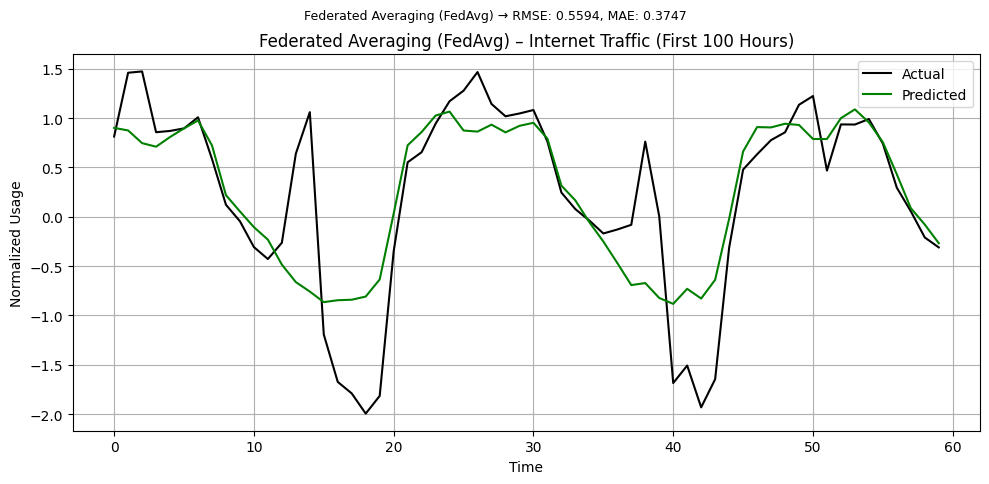

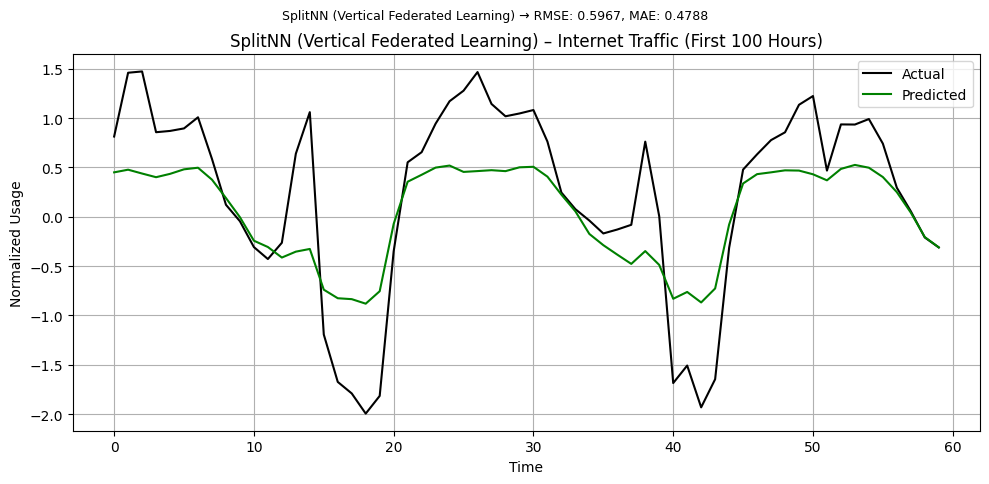

In [34]:
results = []

for traffic_type, target_cols in traffic_groups.items():
    for target in target_cols:
        print(f"\n=== Federated Models for {traffic_type} → Target: {target} ===")

        X_train = train_df.drop(columns=target_cols, errors='ignore')
        X_test  = test_df.drop(columns=target_cols, errors='ignore')
        y_train = train_df[target]
        y_test  = test_df[target]

        # --- FedAvg ---
        mse_fed, mae_fed, y_pred_fed = run_fedavg(X_train, y_train, X_test, y_test)
        results.append(['FedAvg', traffic_type, mse_fed, mae_fed])
        if traffic_type == "Internet":
            plot_results(y_test.values, y_pred_fed, "Federated Averaging (FedAvg)", traffic_type)

        # --- SplitNN ---
        mse_vfl, mae_vfl, y_pred_vfl = run_splitnn(train_df, test_df, target)
        results.append(['VFL', traffic_type, mse_vfl, mae_vfl])
        if traffic_type == "Internet":
            plot_results(y_test.values, y_pred_vfl, "SplitNN (Vertical Federated Learning)", traffic_type)


In [35]:
base_table = pd.read_csv('/content/drive/MyDrive/model_comparison_table.csv')

df_new = pd.DataFrame(results, columns=['Method','Traffic_Type','MSE','MAE'])
df_new = df_new.groupby(['Method','Traffic_Type'], as_index=False).mean()

pivot_mse = df_new.pivot(index='Method', columns='Traffic_Type', values='MSE')
pivot_mae = df_new.pivot(index='Method', columns='Traffic_Type', values='MAE')

federated_table = pd.concat([
    pivot_mse.add_prefix('MSE_'),
    pivot_mae.add_prefix('MAE_')
], axis=1).reset_index()

final_all = pd.concat([base_table, federated_table], ignore_index=True)
for col in ['MSE_SMS','MSE_Call','MSE_Internet','MAE_SMS','MAE_Call','MAE_Internet']:
    if col not in final_all.columns:
        final_all[col] = np.nan

final_all = final_all[['Method','MSE_SMS','MSE_Call','MSE_Internet','MAE_SMS','MAE_Call','MAE_Internet']].round(4)
print("\n=== FINAL COMPARISON TABLE (All 5 Models) ===")
print(final_all)

final_all.to_csv('/content/drive/MyDrive/final_model_comparison_all.csv', index=False)



=== FINAL COMPARISON TABLE (All 5 Models) ===
   Method  MSE_SMS  MSE_Call  MSE_Internet  MAE_SMS  MAE_Call  MAE_Internet
0    LSTM   0.0119    0.0129        0.0109   0.0865    0.0906        0.0743
1   Lasso   0.1086    0.0978        0.3055   0.2645    0.2490        0.3839
2     SVR   0.0337    0.0361        0.2367   0.1334    0.1204        0.2999
3  FedAvg   0.0986    0.0563        0.3129   0.2395    0.1876        0.3747
4     VFL   0.2865    0.3343        0.3560   0.4972    0.5409        0.4788


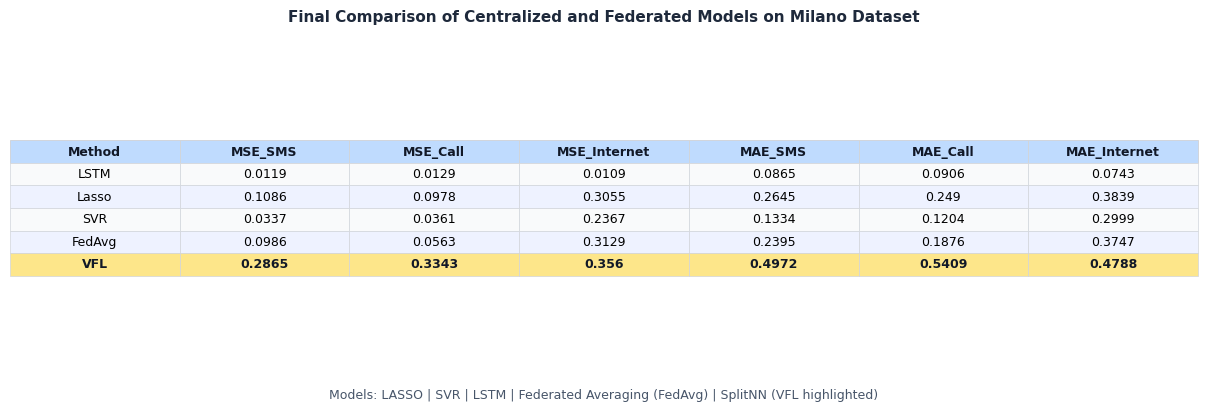

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Load final merged results ---
df = pd.read_csv('/content/drive/MyDrive/final_model_comparison_all.csv')

# --- Create figure and base style ---
fig, ax = plt.subplots(figsize=(11, 3.8))
ax.axis('off')
ax.axis('tight')

# --- Colors ---
header_color = "#bfdbfe"       # soft blue header
default_row_even = "#f9fafb"   # white tint
default_row_odd = "#eef2ff"    # soft lavender
highlight_color = "#fde68a"    # light yellow for VFL row

# --- Build color matrix with highlight for VFL ---
cell_colors = []
for i, method in enumerate(df['Method']):
    if method.strip().lower() == "vfl":  # highlight SplitNN row
        row_color = [highlight_color] * df.shape[1]
    else:
        row_color = [default_row_even if i % 2 == 0 else default_row_odd] * df.shape[1]
    cell_colors.append(row_color)

# --- Create table ---
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colColours=[header_color] * df.shape[1],
    cellColours=cell_colors
)

# --- Styling ---
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.3)

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor("#d1d5db")
    if row == 0:
        cell.set_text_props(weight='bold', color='#111827')
        cell.set_linewidth(0.7)
    else:
        cell.set_linewidth(0.5)
        # Make VFL row text bold
        if df.iloc[row-1]['Method'].strip().lower() == "vfl":
            cell.set_text_props(weight='bold', color='#111827')

# --- Title and caption ---
plt.title(
    "Final Comparison of Centralized and Federated Models on Milano Dataset",
    fontsize=11,
    fontweight='bold',
    pad=25,
    color="#1e293b"
)
plt.figtext(
    0.5, -0.05,
    "Models: LASSO | SVR | LSTM | Federated Averaging (FedAvg) | SplitNN (VFL highlighted)",
    ha="center", fontsize=9, color="#475569"
)

# --- Save high-quality PNG ---
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.05)
plt.savefig("/content/drive/MyDrive/final_model_comparison.png", dpi=400, bbox_inches="tight")
plt.show()
